In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
from mpl_toolkits.axes_grid1 import AxesGrid
from math import ceil

In [11]:
# img = cv2.imread("download.png", cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (42,42))
# img = img.reshape(-1, 42*42)
# a1 = np.array(img)
# size = a1.shape
# imageArray = np.array(img)
# print ("Dimensions of the Image:",imageArray.shape)

data = np.load('train.p')

X_train = np.sum(data['features'], axis=3) / 3   # RGB->grayscale
y_train = data['labels']

data = np.load('test.p')
X_test = np.sum(data['features'], axis=3) / 3   # RGB->grayscale
y_test = data['labels']

# temp = np.zeros(X_train.shape)
# for idx in range(X_train.shape[0]):
#     temp[idx] = cv2.resize(X_train[idx], (42,42))

# for idx in range(X_test.shape[0]):
#     X_test[idx] = cv2.resize(X_test[idx], (42,42))
temp = np.zeros((X_train.shape[0],32*32))
for idx in range(X_train.shape[0]):
    temp[idx] = X_train[idx].reshape(32*32)
X_train = temp

temp = np.zeros((X_test.shape[0],32*32))
for idx in range(X_test.shape[0]):
    temp[idx] = X_test[idx].reshape(32*32)
X_test = temp

In [12]:
import tensorflow as tf


def transformer(U, theta, out_size, name='SpatialTransformer', **kwargs):

    def _repeat(x, n_repeats):
        with tf.variable_scope('_repeat'):
            rep = tf.transpose(
                tf.expand_dims(tf.ones(shape=tf.stack([n_repeats, ])), 1), [1, 0])
            rep = tf.cast(rep, 'int32')
            x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
            return tf.reshape(x, [-1])

    def _interpolate(im, x, y, out_size):
        with tf.variable_scope('_interpolate'):
            # constants
            num_batch = tf.shape(im)[0]
            height = tf.shape(im)[1]
            width = tf.shape(im)[2]
            channels = tf.shape(im)[3]

            x = tf.cast(x, 'float32')
            y = tf.cast(y, 'float32')
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            zero = tf.zeros([], dtype='int32')
            max_y = tf.cast(tf.shape(im)[1] - 1, 'int32')
            max_x = tf.cast(tf.shape(im)[2] - 1, 'int32')

            # scale indices from [-1, 1] to [0, width/height]
            x = (x + 1.0)*(width_f) / 2.0
            y = (y + 1.0)*(height_f) / 2.0

            # do sampling
            x0 = tf.cast(tf.floor(x), 'int32')
            x1 = x0 + 1
            y0 = tf.cast(tf.floor(y), 'int32')
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, zero, max_x)
            x1 = tf.clip_by_value(x1, zero, max_x)
            y0 = tf.clip_by_value(y0, zero, max_y)
            y1 = tf.clip_by_value(y1, zero, max_y)
            dim2 = width
            dim1 = width*height
            base = _repeat(tf.range(num_batch)*dim1, out_height*out_width)
            base_y0 = base + y0*dim2
            base_y1 = base + y1*dim2
            idx_a = base_y0 + x0
            idx_b = base_y1 + x0
            idx_c = base_y0 + x1
            idx_d = base_y1 + x1

            # use indices to lookup pixels in the flat image and restore
            # channels dim
            im_flat = tf.reshape(im, tf.stack([-1, channels]))
            im_flat = tf.cast(im_flat, 'float32')
            Ia = tf.gather(im_flat, idx_a)
            Ib = tf.gather(im_flat, idx_b)
            Ic = tf.gather(im_flat, idx_c)
            Id = tf.gather(im_flat, idx_d)

            # and finally calculate interpolated values
            x0_f = tf.cast(x0, 'float32')
            x1_f = tf.cast(x1, 'float32')
            y0_f = tf.cast(y0, 'float32')
            y1_f = tf.cast(y1, 'float32')
            wa = tf.expand_dims(((x1_f-x) * (y1_f-y)), 1)
            wb = tf.expand_dims(((x1_f-x) * (y-y0_f)), 1)
            wc = tf.expand_dims(((x-x0_f) * (y1_f-y)), 1)
            wd = tf.expand_dims(((x-x0_f) * (y-y0_f)), 1)
            output = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
            return output

    def _meshgrid(height, width):
        with tf.variable_scope('_meshgrid'):
            # This should be equivalent to:
            #  x_t, y_t = np.meshgrid(np.linspace(-1, 1, width),
            #                         np.linspace(-1, 1, height))
            #  ones = np.ones(np.prod(x_t.shape))
            #  grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
            x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                            tf.transpose(tf.expand_dims(tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
            y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                            tf.ones(shape=tf.stack([1, width])))

            x_t_flat = tf.reshape(x_t, (1, -1))
            y_t_flat = tf.reshape(y_t, (1, -1))

            ones = tf.ones_like(x_t_flat)
            grid = tf.concat([x_t_flat, y_t_flat, ones], 0)
            return grid

    def _transform(theta, input_dim, out_size):
        with tf.variable_scope('_transform'):
            num_batch = tf.shape(input_dim)[0]
            height = tf.shape(input_dim)[1]
            width = tf.shape(input_dim)[2]
            num_channels = tf.shape(input_dim)[3]
            theta = tf.reshape(theta, (-1, 2, 3))
            theta = tf.cast(theta, 'float32')

            # grid of (x_t, y_t, 1), eq (1) in ref [1]
            height_f = tf.cast(height, 'float32')
            width_f = tf.cast(width, 'float32')
            out_height = out_size[0]
            out_width = out_size[1]
            grid = _meshgrid(out_height, out_width)
            grid = tf.expand_dims(grid, 0)
            grid = tf.reshape(grid, [-1])
            grid = tf.tile(grid, tf.stack([num_batch]))
            grid = tf.reshape(grid, tf.stack([num_batch, 3, -1]))

            # Transform A x (x_t, y_t, 1)^T -> (x_s, y_s)
            T_g = tf.matmul(theta, grid)
            x_s = tf.slice(T_g, [0, 0, 0], [-1, 1, -1])
            y_s = tf.slice(T_g, [0, 1, 0], [-1, 1, -1])
            x_s_flat = tf.reshape(x_s, [-1])
            y_s_flat = tf.reshape(y_s, [-1])

            input_transformed = _interpolate(
                input_dim, x_s_flat, y_s_flat,
                out_size)
            output = tf.reshape(
                input_transformed, tf.stack([num_batch, out_height, out_width, num_channels]))
            return output

    with tf.variable_scope(name):
        output = _transform(theta, U, out_size)
        return output


def batch_transformer(U, thetas, out_size, name='BatchSpatialTransformer'):
    with tf.variable_scope(name):
        num_batch, num_transforms = map(int, thetas.get_shape().as_list()[:2])
        indices = [[i]*num_transforms for i in xrange(num_batch)]
        input_repeated = tf.gather(U, tf.reshape(indices, [-1]))
        return transformer(input_repeated, thetas, out_size)

In [13]:
def weight_variable(shape, name=""):
    initial = tf.zeros(shape)
    return tf.Variable(initial, name=name)
def bias_variable(shape, name=""):
    initial = tf.random_normal(shape, mean = 0.0, stddev=0.01)
    return tf.Variable(initial, name= name)

In [14]:
def demo_simple_grid(images, figname=None, cmap='gray', axes_pad=0.05):
    grid_size = int(ceil(images.shape[0] ** 0.5))
    fig = plt.figure()
    grid = AxesGrid(fig, 111, nrows_ncols = (grid_size, grid_size), axes_pad = axes_pad)
    for i in range(images.shape[0]):
        im = grid[i].imshow(images[i], cmap=cmap)
        if figname is None:
            plt.show()
        else:
            plt.savefig(figname)
    plt.close("all")

In [15]:
x = tf.placeholder(tf.float32, [34799, 32*32])

In [16]:
W_loc1 = weight_variable([32*32, 1024], name='W_loc1')
b_loc1 = bias_variable([1024], name='b_loc1')
h_loc1 = tf.nn.relu(tf.matmul(x, W_loc1) + b_loc1)
W_loc2 = weight_variable([1024, 256], name='W_loc2')
b_loc2 = bias_variable([256], name='b_loc2')
h_loc2 = tf.nn.relu(tf.matmul(h_loc1, W_loc2) + b_loc2)
W_loc3 = tf.Variable(initial_value=tf.zeros([256, 6], tf.float32), name='W_loc3')

# b_loc3 = tf.Variable(initial_value=[0.1, 0.707, 0.0, -0.707, 0.1 ,0.0], name='b_loc3')
b_loc3 = tf.Variable(initial_value=[1., 0., 0.0, 0., 1. ,0.0], name='b_loc3')

h_loc3 = tf.matmul(h_loc2, W_loc3) + b_loc3

x_tensor = tf.reshape(x, [-1, 32, 32, 1])
out_size = (32, 32)
h_trans = transformer(x_tensor, h_loc3, out_size)
stn_weights=[W_loc1, W_loc2, W_loc3]
stn_biases=[b_loc1, b_loc2, b_loc3]


In [17]:
print(X_train.shape)
sess = tf.Session()
sess.run(tf.initialize_all_variables())
gen_images = sess.run(
                        h_trans, 
                        feed_dict={
                            x:X_train,
#                             y:batch_ys
                        }
                    )

(34799, 1024)


Tensor("SpatialTransformer_1/_transform/Reshape_5:0", shape=(34799, 32, 32, 1), dtype=float32)
(34799, 32, 32, 1)


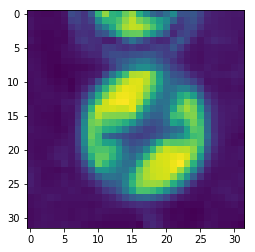

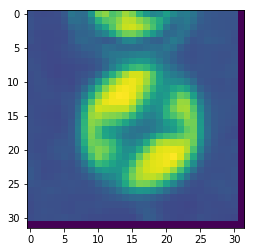

In [24]:
print(h_trans)
print(gen_images.shape)
plt.imshow(X_train[0].reshape(32,32))
plt.pause(0.2)
plt.imshow(gen_images[0].reshape(32,32))

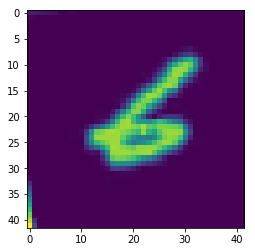

In [202]:
plt.imshow(gen_images[0,:,:,0])

In [20]:
h_trans_flat = tf.reshape(h_trans, [-1, 42*42])
W_clsfr_1 = weight_variable([42*42, 1024], name='W_clsfr_1')
b_clsfr_1 = bias_variable([1024], name='b_clsfr_1')
h_clsfr_1 = tf.nn.relu(
                tf.matmul(h_trans_flat, W_clsfr_1) + b_clsfr_1
            )
W_clsfr_2 = weight_variable([1024, 256], name='W_clsfr_2')
b_clsfr_2 = bias_variable([256], name='b_clsfr_2')
h_clsfr_2 = tf.nn.relu(
                tf.matmul(h_clsfr_1, W_clsfr_2) + b_clsfr_2
            )
W_clsfr_3 = weight_variable([256, 10], name='W_clsfr_3')
b_clsfr_3 = bias_variable([10], name='b_clsfr_3')
y_logits  = tf.matmul(h_clsfr_2, W_clsfr_3) + b_clsfr_3
clsfr_weights=[W_clsfr_1, W_clsfr_2, W_clsfr_3]
clsfr_biases=[b_clsfr_1, b_clsfr_2, b_clsfr_3]